# FOB Data Pre-Processing for Modeling

## Setup and Library Imports

In [1]:
# Install module for specific python version
! python3.10 -m pip install mlxtend -q

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

In [3]:
# Display entire dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Load Data

In [5]:
fob_songs = pd.read_csv('data/processed/FOB_songs_processed.csv', index_col=0)

In [6]:
# Rearrange columns with numbers on the left and categoricals on the right
fob_songs = fob_songs[['title', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'total_words', 'unique_words', 'duration_min',
           'key', 'mode', 'time_signature', 'class']]
fob_songs.head()

,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key,mode,time_signature,class
0,Honorable Mention,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,103.858,201,74,3.43,5,1,4,pre-hiatus
1,Calm Before the Storm,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,173.643,289,141,4.73,9,1,4,pre-hiatus
2,Switchblades and Infidelity,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,135.163,165,45,3.24,11,1,4,pre-hiatus
3,Pretty In Punk,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,125.773,249,85,3.62,9,1,4,pre-hiatus
4,Growing Up,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,149.928,174,94,2.82,0,1,3,pre-hiatus


In [7]:
# Confirm no null values
fob_songs.isnull().sum().sum()

0

### Comparing Numeric Features
Compare means and medians from each numerical column across the pre and post-hiatus classes to determine which features show the most skewness

In [8]:
pre = fob_songs[fob_songs['class'] == 'pre-hiatus']
post = fob_songs[fob_songs['class'] == 'post-hiatus']
numeric= fob_songs.columns[1:-4].values
categorical = fob_songs.columns[-4:].values
pre_means, pre_medians, post_means, post_medians = [], [], [], []

In [9]:
for col in numeric:
    pre_means.append(pre[col].mean())
    post_means.append(post[col].mean())
    pre_medians.append(pre[col].median())
    post_medians.append(post[col].median())

In [10]:
# Set up dataframe to compare each mean and median with their deltas
num_features = DataFrame({'feature': numeric, 'pre-hiatus_mean': pre_means,
                         'post-hiatus_mean': post_means, 'pre-hiatus_median': pre_medians,
                         'post-hiatus_median': post_medians})
num_features['mean_delta'] = num_features['pre-hiatus_mean'] - num_features['post-hiatus_mean']
num_features['median_delta'] = num_features['pre-hiatus_median'] - num_features['post-hiatus_median']

In [11]:
num_features

,feature,pre-hiatus_mean,post-hiatus_mean,pre-hiatus_median,post-hiatus_median,mean_delta,median_delta
0,danceability,0.503910,0.501096,0.49300,0.522500,0.002814,-0.029500
1,energy,0.895124,0.884673,0.93900,0.906500,0.010451,0.032500
2,loudness,-4.129865,-4.043577,-3.84300,-3.836500,-0.086288,-0.006500
3,speechiness,0.091297,0.086667,0.07020,0.059400,0.004629,0.010800
4,acousticness,0.035990,0.021782,0.00278,0.006285,0.014208,-0.003505
5,instrumentalness,0.000052,0.044889,0.00000,0.000059,-0.044838,-0.000059
6,liveness,0.294708,0.285040,0.28400,0.237500,0.009667,0.046500
7,valence,0.541787,0.523212,0.54500,0.546500,0.018575,-0.001500
8,tempo,139.904022,136.425692,135.45000,137.030000,3.478330,-1.580000
9,total_words,289.438202,335.115385,285.00000,335.500000,-45.677182,-50.500000


### Comparing Categorical Features

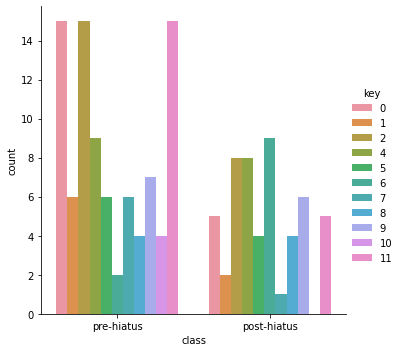

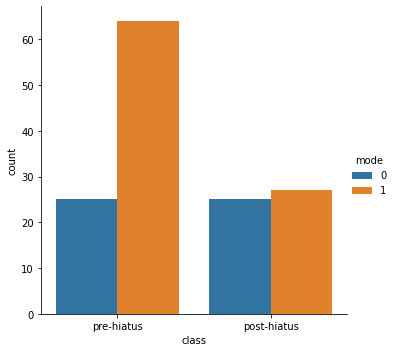

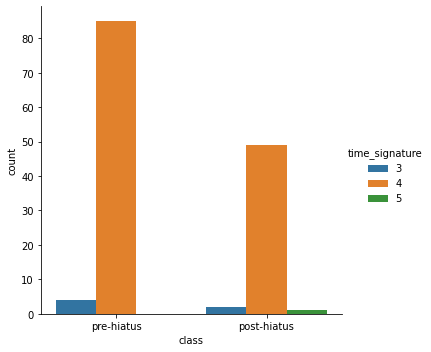

In [12]:
for col in fob_songs[categorical[:-1]]:
	sns.catplot(x='class', hue = col, kind = 'count', data = fob_songs)

### Categorical Features: Conclusion
- Mode should be a feature because a minor song is a good predictor of pre-hiatus
- Unsure if Key should be included as a feature
- Definitely exclude Time Signature from final model, as most are 4/4

In [13]:
features = fob_songs.copy()
features.head()

,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,key,mode,time_signature,class
0,Honorable Mention,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,103.858,201,74,3.43,5,1,4,pre-hiatus
1,Calm Before the Storm,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,173.643,289,141,4.73,9,1,4,pre-hiatus
2,Switchblades and Infidelity,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,135.163,165,45,3.24,11,1,4,pre-hiatus
3,Pretty In Punk,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,125.773,249,85,3.62,9,1,4,pre-hiatus
4,Growing Up,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,149.928,174,94,2.82,0,1,3,pre-hiatus


### Feature Scaling
- With multiple variables on different scales, we'll need feature scaling.
- Many variables in this dataset are already on the scale of 0-1, so we'll simply use MinMax Scaler to place the other variables on this scale as well

In [14]:
unscaled_cols = ['tempo', 'total_words', 'unique_words', 'duration_min']
unscaled = features[unscaled_cols]
unscaled.head()

,tempo,total_words,unique_words,duration_min
0,103.858,201,74,3.43
1,173.643,289,141,4.73
2,135.163,165,45,3.24
3,125.773,249,85,3.62
4,149.928,174,94,2.82


In [15]:
# MinMaxScaler yields features scaled from 0-1
scaled = MinMaxScaler().fit_transform(unscaled)
scaled = DataFrame(scaled, columns=unscaled_cols)
scaled.head()

,tempo,total_words,unique_words,duration_min
0,0.187815,0.218094,0.221106,0.626316
1,0.736349,0.360258,0.557789,0.968421
2,0.433883,0.159935,0.075377,0.576316
3,0.360074,0.295638,0.276382,0.676316
4,0.549941,0.174475,0.321608,0.465789


### Encoding
One-Hot Encode categorical variables

In [16]:
one = OneHotEncoder(sparse=False)
numbers = features[numeric].iloc[:,:-4].copy()
categories_df = features[['key', 'time_signature']].copy()
cols = categories_df.columns

In [17]:
# Rough by-hand label-encoding of class column
# Pre-hiatus maps to 0; Post-hiatus maps to 1
features = features.replace('pre-hiatus', 0.0).replace('post-hiatus', 1.0)
features['class'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float64

In [18]:
cats_encoded = one.fit_transform(categories_df)
feature_names = one.get_feature_names_out(cols)

In [19]:
# df of one-hot-encoded variables
cats_df = DataFrame(cats_encoded, columns=feature_names)
cats_df.head()

,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
new_mode = features['mode'].astype('float16').copy()

In [22]:
# Concatenate dataframes and reorder columns
# Numbers, scaled data, mode, categories (key/time_sig), class 
features = pd.concat([numbers, scaled, new_mode, cats_df, features['class'].copy()], axis='columns')
print(features.shape)
features.head()

(141, 28)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_words,unique_words,duration_min,mode,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,class
0,0.384,0.969,-3.903,0.0985,0.00236,0.000000,0.277,0.374,0.187815,0.218094,0.221106,0.626316,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.338,0.919,-5.538,0.3160,0.00391,0.000251,0.307,0.464,0.736349,0.360258,0.557789,0.968421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.374,0.990,-4.092,0.3800,0.00673,0.000003,0.250,0.336,0.433883,0.159935,0.075377,0.576316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.430,0.963,-4.803,0.1610,0.00347,0.000000,0.298,0.268,0.360074,0.295638,0.276382,0.676316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.291,0.971,-4.066,0.3010,0.00926,0.000000,0.287,0.408,0.549941,0.174475,0.321608,0.465789,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Export all features before feature selection

In [27]:
features.to_csv('data/processed/all_encoded.csv')

### Data Split

In [28]:
y = features.pop('class')

### Backward Feature Selection
- Minimum of 3 features, maximum 12
- Scored with F1

In [29]:
backward = SequentialFeatureSelector(LogisticRegression(max_iter=5000),
                                     k_features=(2, 8),
                                     forward=False, floating=True,
                                     verbose=2, scoring='f1', cv=3)

In [30]:
backward.fit(features, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.4s finished

[2022-10-05 09:53:16] Features: 26/2 -- score: 0.3814696106362773[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.0s finished

[2022-10-05 09:53:17] Features: 25/2 -- score: 0.39969834087481143[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_j

SequentialFeatureSelector(cv=3, estimator=LogisticRegression(max_iter=5000),
                          floating=True, forward=False, k_features=(2, 8),
                          scoring='f1', verbose=2)

In [31]:
final_features = list(backward.k_feature_names_)
final_features

['danceability',
 'instrumentalness',
 'total_words',
 'mode',
 'key_6',
 'key_9',
 'key_10',
 'key_11']

In [32]:
# Model score
backward.k_score_

0.4975308641975309

### Export final features for modeling

In [33]:
selected_features = features[final_features]
selected_features = pd.concat([selected_features, y], axis=1)

In [34]:
selected_features.head()

,danceability,instrumentalness,total_words,mode,key_6,key_9,key_10,key_11,class
0,0.384,0.000000,0.218094,1.0,0.0,0.0,0.0,0.0,0.0
1,0.338,0.000251,0.360258,1.0,0.0,1.0,0.0,0.0,0.0
2,0.374,0.000003,0.159935,1.0,0.0,0.0,0.0,1.0,0.0
3,0.430,0.000000,0.295638,1.0,0.0,1.0,0.0,0.0,0.0
4,0.291,0.000000,0.174475,1.0,0.0,0.0,0.0,0.0,0.0


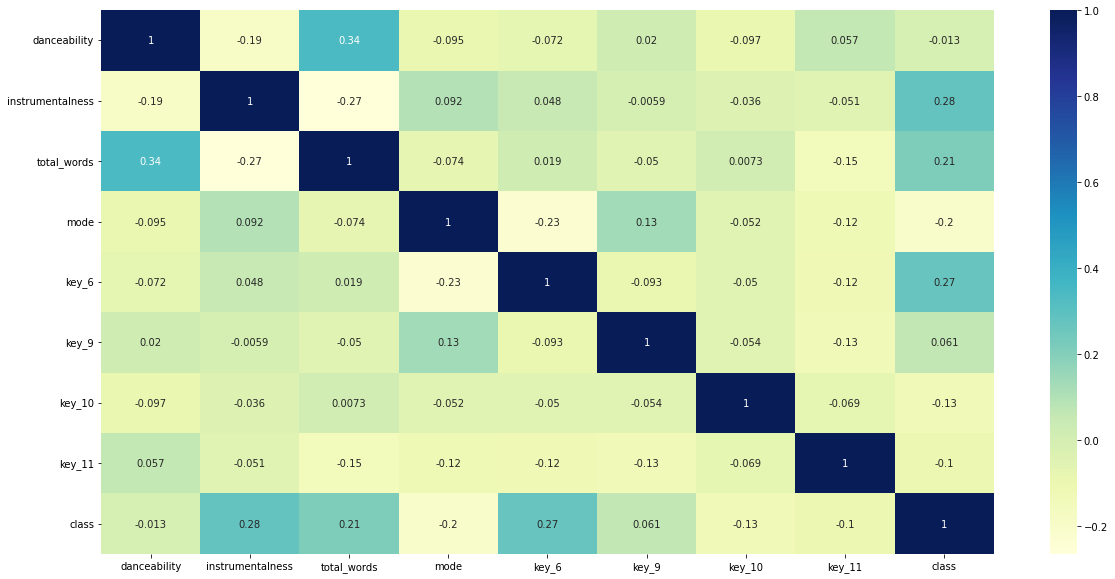

In [35]:
# No significant correlations
plt.figure(figsize=(20,10))
sns.heatmap(selected_features.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [36]:
selected_features.to_csv('data/processed/features_encoded.csv')

### Experiment with different feature combinations

In [37]:
features.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'total_words',
       'unique_words', 'duration_min', 'mode', 'key_0', 'key_1', 'key_2',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [38]:
feature_ideas = ['valence', 'total_words', 'liveness', 'mode', 'key_11']
exp_features = features[feature_ideas].copy()
exp_features = pd.concat([exp_features, y], axis=1)
exp_features.head()

,valence,total_words,liveness,mode,key_11,class
0,0.374,0.218094,0.277,1.0,0.0,0.0
1,0.464,0.360258,0.307,1.0,0.0,0.0
2,0.336,0.159935,0.250,1.0,1.0,0.0
3,0.268,0.295638,0.298,1.0,0.0,0.0
4,0.408,0.174475,0.287,1.0,0.0,0.0


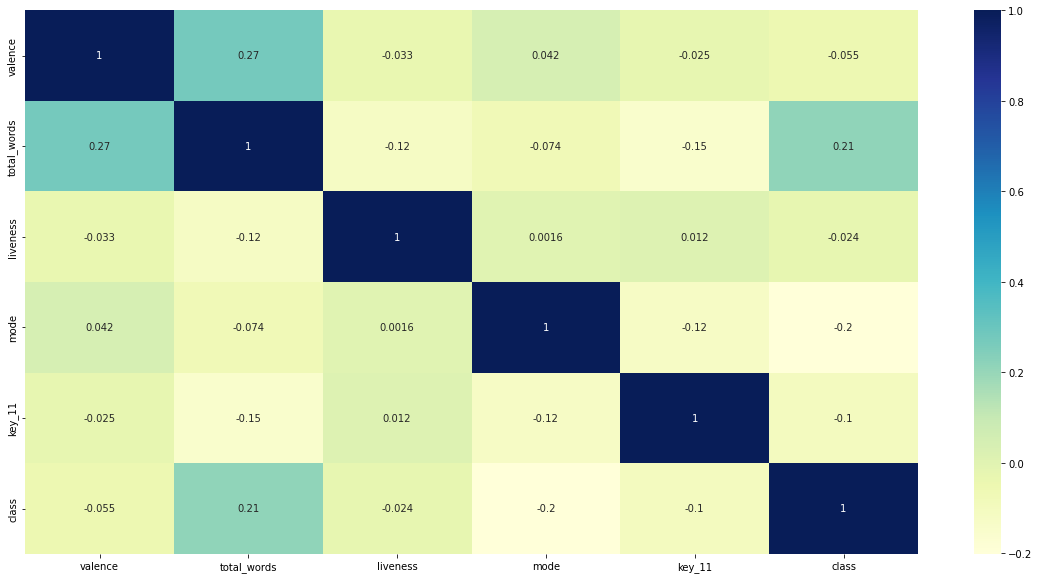

In [39]:
# No significant correlations
plt.figure(figsize=(20,10))
sns.heatmap(exp_features.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [40]:
exp_features.to_csv('data/processed/exp_features_encoded.csv')